# Práctica 3 parte B: Superpixeles
- Martínez Ostoa Néstor Iván
- Ramírez Bondi Jorge Alejandro

**Reconocimiento de Patrones - 0757**

**Facultad de Ingeniería, UNAM**

# Arquitectura Propuesta

La idea de esta práctica es utilizar *superpixeles* (Ren, Malik. 2003) para un 
proceso de clasificación de imágenes utilizando dos algoritmos de clasificación: 
1) K-Means y 2) KNN. Las imágenes utilizadas en esta práctica fueron tomadas por 
2) satélites de zonas urbanas. 

Nuestra arquitectura diseñada sigue los siguientes pasos: 

## Entrenamiento
1. Lectura de imágenes de entrenamiento
2. Segmentación de imagen utilizando $k$ *superpixeles*
3. Para cada *superpixel*:
   1. Extracción de características mediante un análisis de textura (Haralick)
   2. Generación de conjuntos de entrenamiento (vector de características, etiquetas)
4. Para cada conjunto de entrenamiento:
   1. Entrenamiento con el clasificador K-Means
   2. Entrenamiento con el clasificador KNN
   
## Prueba
1. Lectura de imágenes de prueba
2. Segmentación de imagen utilizando $k$ *superpixeles*
3. Para cada *superpixel*:
   1. Extracción de características mediante un análisis de textura
   2. Generación de conjuntos de prueba (vector de características)
4. Para cada conjunto de prueba:
   1. Evaluación con el clasificador previamente entrenado K-Means
   2. Evaluación con el clasificador previamente entrenado KNN

# Resultados

Los resultados de esta práctica estarán dados en relacción el hiperparámetro $k$
que indica la cantidad de *superpixeles* a utilizar para cada imagen. 

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import cv2
import os
from PIL import Image, ImageOps
from skimage.segmentation import slic, mark_boundaries

In [152]:
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'
TRAIN_SUPERPIXELS_PATH = 'data/train_superpixels/'
TEST_SUPERPIXELS_PATH = 'data/test_superpixels/'

In [11]:
def get_image(path, flag=cv2.IMREAD_COLOR):
    return cv2.imread(path, cv2.COLOR_BGR2RGB)

def convert_to_gray(rgb_image):
    return cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

def get_images_names(path):
    imgs_names = os.listdir(path)
    return [name for name in imgs_names if name[0] != '.']

def convert_to_gray(rgb_image):
    return cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)    

In [4]:
def get_segments(img, k, compactness, sigma=None):
    return slic(img, n_segments=k, compactness=compactness, start_label=1, sigma=sigma)

def show_img_with_segments(img, segments=None, k=None, compactness=None, axis=None):
    if segments is None:
        if k is None or compactness is None: 
            raise Exception("'k' and 'compactnes' should have value")
        segments = get_segments(img, k, compactness)
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(2,2,1)
    if axis is None: ax.axis('off')
    ax.set_title(f'Image with k={k} superpixels\nCompactness level: {compactness}')
    plt.imshow(mark_boundaries(img, segments))
    plt.tight_layout()
    plt.show()

def show_img_with_ks(img, Ks, Cs, img_name=None):
    """
    Ks: array of number of superpixels
    Cs: array of compactness for each K
    """
    if len(Ks) == 1: 
        show_img_with_segments(img, Ks[0], Cs[0])
        return
    fig, ax = plt.subplots(
        nrows=1, ncols=len(Ks), sharex=True, sharey=True,
        figsize=(10,10)
    )
    for idx, k in enumerate(Ks):
        c = Cs[0] if idx >= len(Cs) else Cs[idx]
        segments = get_segments(img, k, c)
        ax[idx].imshow(mark_boundaries(img, segments))
        if img_name is None: ax[idx].set_title(f'K: {k} superpixels\nCompactnes: {c}')
        else: ax[idx].set_title(f'{img_name}\nK: {k} superpixels\nCompactnes: {c}')
        ax[idx].axis('off')
    plt.tight_layout()
    plt.show()

Processing p3.PNG


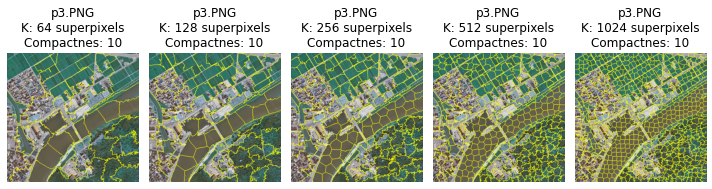

Processing p2.PNG


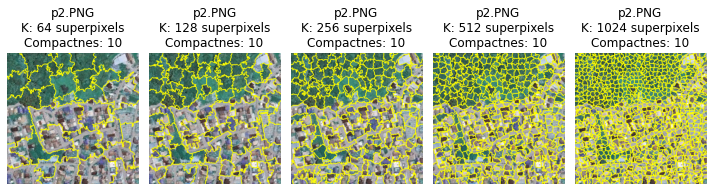

Processing p1.PNG


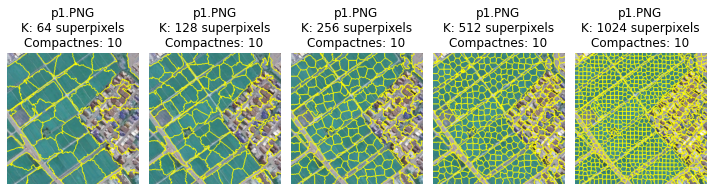

In [112]:
train_imgs_names = get_images_names(TRAIN_PATH)
for img_name in train_imgs_names:
    print(f'Processing {img_name}')
    img = get_image(TRAIN_PATH + img_name)
    show_img_with_ks(img, Ks=Ks, Cs=Cs, img_name=img_name)

## Extracción de superpixeles

In [154]:
def extract_relevant_pixels(img):
    min_col = 300
    max_col = -1
    min_row = 300
    max_row = -1
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            pixel = img[row][col]
            if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0: #black pixel
                pass 
            else:
                if row < min_row: min_row = row
                if row > max_row: max_row = row
                if col < min_col: min_col = col
                if col > max_col: max_col = col
    return img[min_row:max_row, min_col:max_col]

In [5]:
def extract_superpixels(img, segments):
    superpixels = []
    for (i, seg_val) in enumerate(np.unique(segments)):
        mask = np.zeros(img.shape[:2], dtype='uint8')
        mask[segments == seg_val] = 255
        s = cv2.bitwise_and(img, img, mask=mask)
        s = extract_relevant_pixels(s)
        superpixels.append(s)
    return superpixels

In [6]:
def save_images(name, imgs, path):
    try: os.mkdir(path)
    except OSError as error: pass
    name = name.split('.')[0]
    for idx, image in enumerate(imgs):
        image_name = name + '_' + str(idx) + '.png'
        image = Image.fromarray(image)
        image.save(path + image_name)

In [278]:
Ks = [64, 128, 256]
compactness = 10
train_images = get_images_names(TRAIN_PATH)
for img_name in train_images:
    print(f'Processing image: {img_name}')
    img = get_image(TRAIN_PATH + img_name)
    for k in Ks:
        segments = get_segments(img, k, compactness)
        superpixels = extract_superpixels(img, segments)
        save_images(img_name, superpixels, path=TRAIN_SUPERPIXELS_PATH + str(k) + '_spx/')

Processing image: p3.PNG
Processing image: p2.PNG
Processing image: p1.PNG


## Extracción de características de Haralick

In [112]:
from skimage.feature import greycomatrix, greycoprops
from sklearn import preprocessing

In [113]:
def convert2gray(img_path):
    img = Image.open(img_path)
    img = ImageOps.grayscale(img)
    return np.array(np.asarray(img))

def sort_spx_sizes(spx_sizes):
    k_sizes = []
    for k in spxs_sizes:
        k_sizes.append(int(k.split('_')[0]))
    labels = []
    for k in sorted(k_sizes):
        labels.append(str(k) + '_spx')
    return labels

In [114]:
# GLCM parameters: distances, angles
distances = [1]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

X_train_all = []
y_train_all = []

le = preprocessing.LabelEncoder()

spxs_sizes = get_images_names(TRAIN_SUPERPIXELS_PATH)
spxs_sizes = sort_spx_sizes(spxs_sizes)
for k_spx in spxs_sizes:
    print(f"Processing: {k_spx}")
    class_path = TRAIN_SUPERPIXELS_PATH + k_spx + '/'
    class_names = get_images_names(class_path)
    k = k_spx.split('_')[0]
    y_train = []
    X_train = []
    for class_name in class_names:
        image_names = get_images_names(class_path + class_name + '/')
        for img_name in image_names:
            img_path = class_path + class_name + '/' + img_name
            img = convert2gray(img_path)            
            glcm = greycomatrix(img, distances, angles)
            features = [
                np.mean(greycoprops(glcm, 'contrast')),
                np.mean(greycoprops(glcm, 'dissimilarity')),
                np.mean(greycoprops(glcm, 'homogeneity')),
                np.mean(greycoprops(glcm, 'energy')),
                np.mean(greycoprops(glcm, 'correlation')),
                np.mean(greycoprops(glcm, 'ASM')),
            ]
            X_train.append(np.array(features))
            y_train.append(class_name)
    X_train_all.append(np.array(X_train))
    # Label encoding
    y_train_all.append(le.fit_transform(np.array(y_train)))

Processing: 64_spx
Processing: 128_spx
Processing: 256_spx


In [115]:
for idx, k_size in enumerate(spxs_sizes):
    print(f'k_size: {k_size}')
    print(f'\tX_train_all: {len(X_train_all[idx])}')
    print(f'\ty_train_all: {len(y_train_all[idx])}')

k_size: 64_spx
	X_train_all: 110
	y_train_all: 110
k_size: 128_spx
	X_train_all: 232
	y_train_all: 232
k_size: 256_spx
	X_train_all: 515
	y_train_all: 515


In [156]:
print(X_train_all[0][0])
print(y_train_all[0][0])

[1.34813569e+03 1.87435836e+01 2.85559032e-01 2.17636981e-01
 8.70749903e-01 4.74179082e-02]
0


## Entrenamiento

1. KNN
2. kMeans

In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [147]:
knn_trained_models = []
kmeans_trained_models = []
for idx in range(len(spxs_sizes)):
    X = X_train_all[idx]
    y = y_train_all[idx]
    # KNN
    knn_model = KNeighborsClassifier(n_neighbors=4)
    knn_model.fit(X, y)
    knn_trained_models.append(model)

    # kMeans
    kmeans_model = KMeans(n_clusters=4, random_state=0)
    kmeans_model.fit(X, y)
    kmeans_trained_models.append(model)

In [148]:
print(len(knn_trained_models))
print(len(kmeans_trained_models))

3
3


## Evaluación de Modelos
1. KNN
2. kMeans

Primero, obtenemos los superpixeles de la imagen de prueba

In [155]:
Ks = [64, 128, 256]
compactness = 10
train_images = get_images_names(TEST_PATH)
for img_name in train_images:
    print(f'Processing image: {img_name}')
    img = get_image(TEST_PATH + img_name)
    for k in Ks:
        segments = get_segments(img, k, compactness)
        superpixels = extract_superpixels(img, segments)
        save_images(img_name, superpixels, path=TEST_SUPERPIXELS_PATH + str(k) + '_spx/')

Processing image: p4.PNG


In [158]:
# GLCM parameters: distances, angles
distances = [1]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

X_test_all = []
y_test_all = []

le = preprocessing.LabelEncoder()

spxs_sizes = get_images_names(TEST_SUPERPIXELS_PATH)
spxs_sizes = sort_spx_sizes(spxs_sizes)
for k_spx in spxs_sizes:
    print(f"Processing: {k_spx}")
    class_path = TEST_SUPERPIXELS_PATH + k_spx + '/'
    class_names = get_images_names(class_path)
    k = k_spx.split('_')[0]
    y_test = []
    X_test = []
    for class_name in class_names:
        image_names = get_images_names(class_path + class_name + '/')
        for img_name in image_names:
            img_path = class_path + class_name + '/' + img_name
            img = convert2gray(img_path)            
            glcm = greycomatrix(img, distances, angles)
            features = [
                np.mean(greycoprops(glcm, 'contrast')),
                np.mean(greycoprops(glcm, 'dissimilarity')),
                np.mean(greycoprops(glcm, 'homogeneity')),
                np.mean(greycoprops(glcm, 'energy')),
                np.mean(greycoprops(glcm, 'correlation')),
                np.mean(greycoprops(glcm, 'ASM')),
            ]
            X_test.append(np.array(features))
            y_test.append(class_name)
    X_test_all.append(np.array(X_test))
    # Label encoding
    y_test_all.append(le.fit_transform(np.array(y_test)))

Processing: 64_spx
Processing: 128_spx
Processing: 256_spx


In [162]:
for idx, k_size in enumerate(spxs_sizes):
    print(f'k_size: {k_size}')
    print(f'\tX_test_all: {len(X_test_all[idx])}')
    print(f'\ty_test_all: {len(y_test_all[idx])}')

k_size: 64_spx
	X_test_all: 28
	y_test_all: 28
k_size: 128_spx
	X_test_all: 67
	y_test_all: 67
k_size: 256_spx
	X_test_all: 144
	y_test_all: 144


Después, realizamos la predicción

In [186]:
knn_pred = []
kmeans_pred = []
for idx in range(len(spxs_sizes)):
    X = X_test_all[idx]
    # KNN
    knn_model = knn_trained_models[idx]
    knn_pred.append(knn_model.predict(X))

    # kMeans
    kmeans_model = kmeans_trained_models[idx]
    kmeans_pred.append(kmeans_model.predict(X))

## Medida de evaluación

In [187]:
from sklearn.metrics import accuracy_score

In [188]:
print("\t\tACCURACY RESULTS")
for idx, k_size in enumerate(spxs_sizes):
    k_size = k_size.split('_')[0]
    print(f'------------------ k = {k_size} ------------------')
    acc_knn = accuracy_score(y_test_all[idx], knn_pred[idx])
    acc_kmeans = accuracy_score(y_test_all[idx], kmeans_pred[idx])
    print(f'\tKNN: {np.round(acc_knn,2)}\tkMeans: {np.round(acc_kmeans,2)}')

		ACCURACY RESULTS
------------------ k = 64 ------------------
	KNN: 0.25	kMeans: 0.25
------------------ k = 128 ------------------
	KNN: 0.22	kMeans: 0.22
------------------ k = 256 ------------------
	KNN: 0.21	kMeans: 0.21


## Máscaras de segmentación